In [95]:
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [96]:
modcod_df = pd.read_excel('modcods_dvbs2.xlsx', index_col='acm')

In [97]:
print(modcod_df)

    order_name  order   rate                label         label_string  isend  \
acm                                                                             
0         QPSK      2   1/4      DVB-S2 QPSK 1/4      DVB_S2_QPSK_1r4   -2.35   
1         QPSK      2   1/3      DVB-S2 QPSK 1/3      DVB_S2_QPSK_1r3   -1.24   
2         QPSK      2   2/5      DVB-S2 QPSK 2/5      DVB_S2_QPSK_2r5   -0.30   
3         QPSK      2   1/2      DVB-S2 QPSK 1/2      DVB_S2_QPSK_1r2    1.00   
4         QPSK      2   3/5      DVB-S2 QPSK 3/5      DVB_S2_QPSK_3r5    2.23   
5         QPSK      2   2/3      DVB-S2 QPSK 2/3      DVB_S2_QPSK_2r3    3.10   
6         QPSK      2   3/4      DVB-S2 QPSK 3/4      DVB_S2_QPSK_3r4    4.03   
7         QPSK      2   4/5      DVB-S2 QPSK 4/5      DVB_S2_QPSK_4r5    4.68   
8         QPSK      2   5/6      DVB-S2 QPSK 5/6      DVB_S2_QPSK_5r6    5.18   
9         QPSK      2   8/9      DVB-S2 QPSK 8/9      DVB_S2_QPSK_8r9    6.20   
10        QPSK      2  9/10 

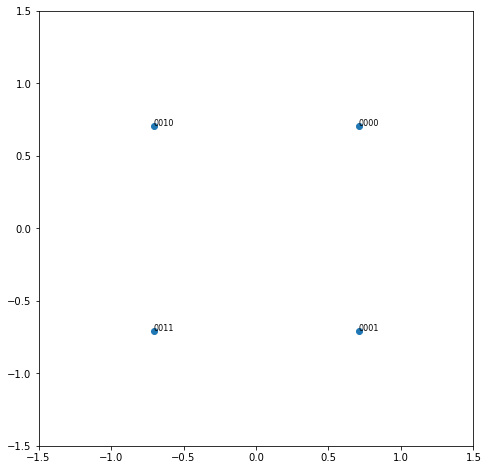

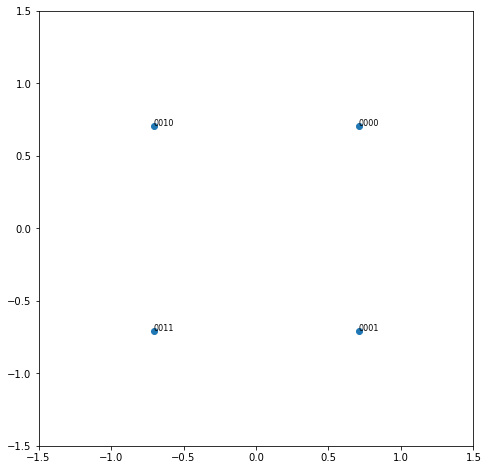

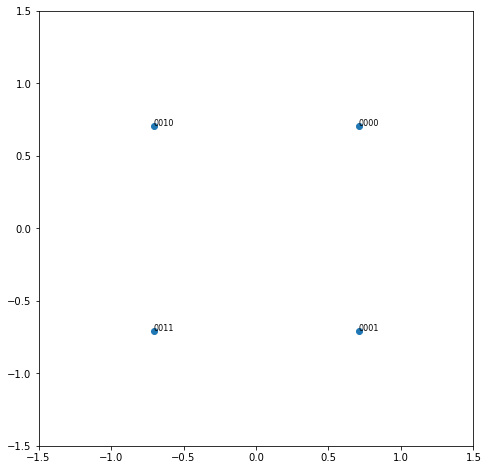

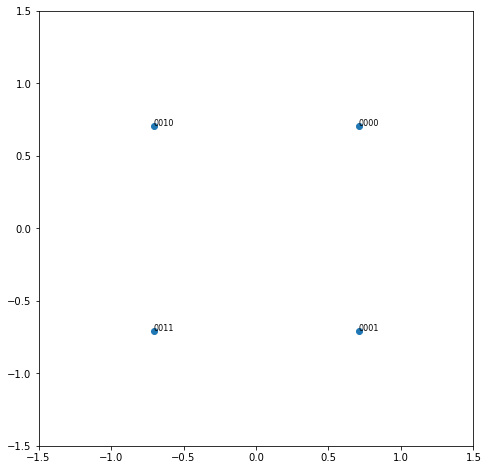

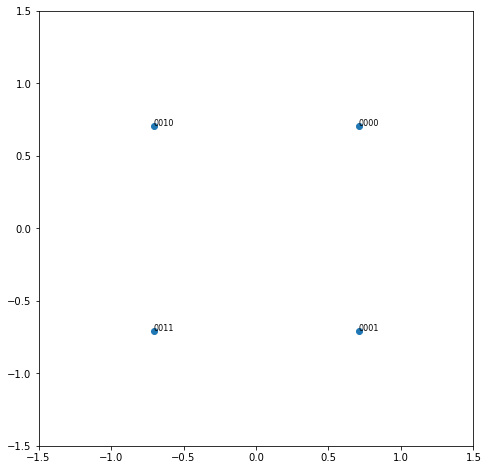

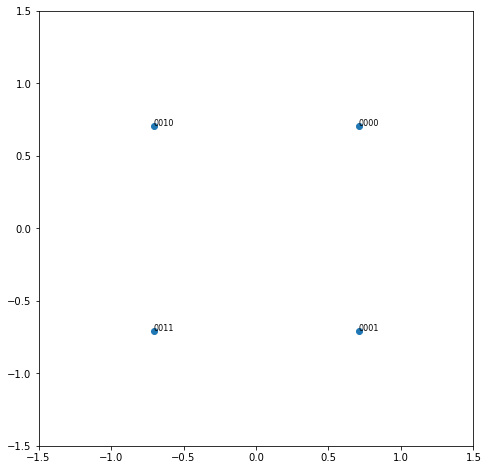

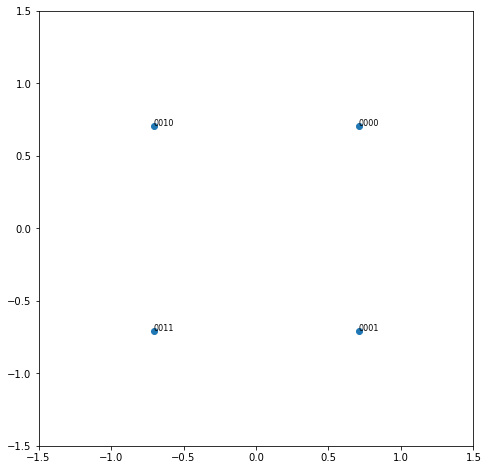

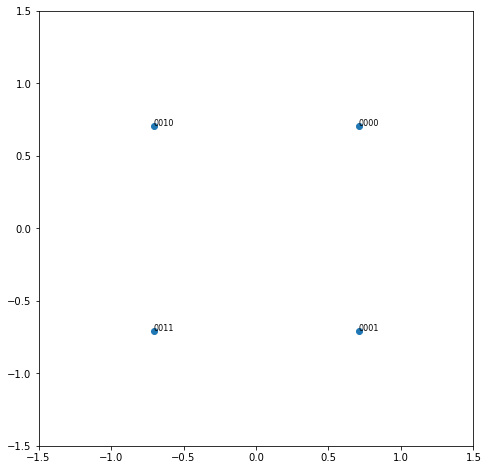

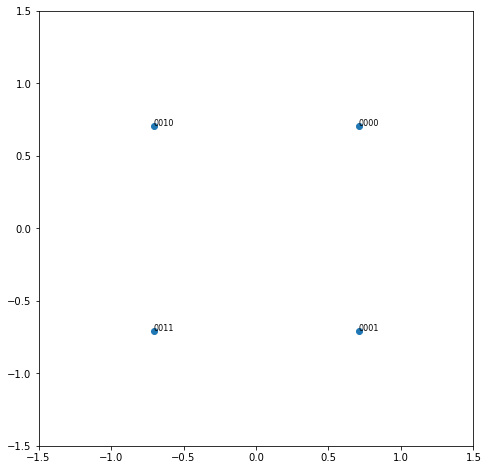

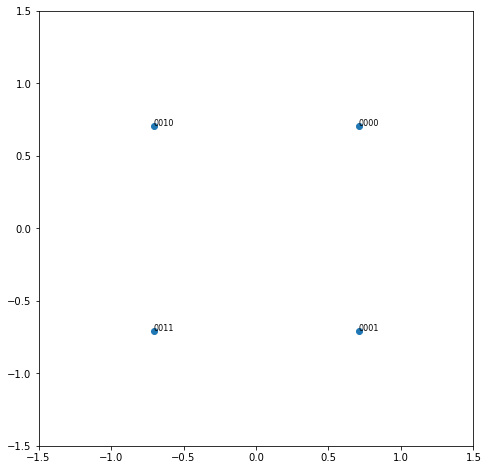

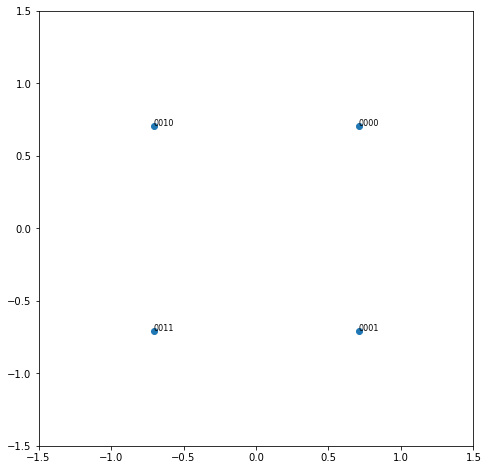

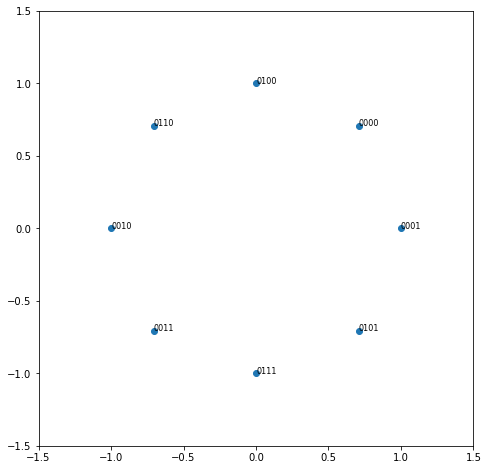

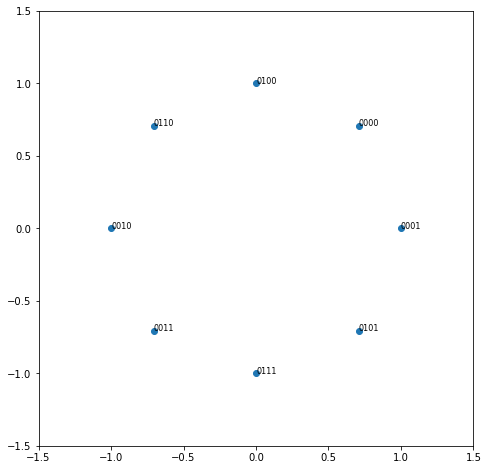

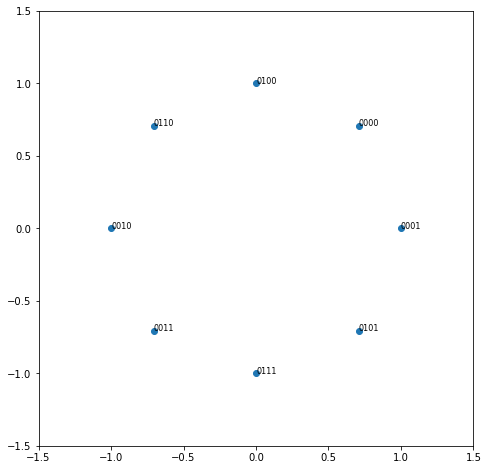

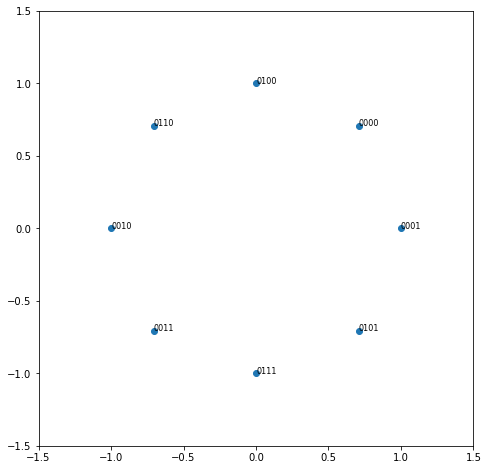

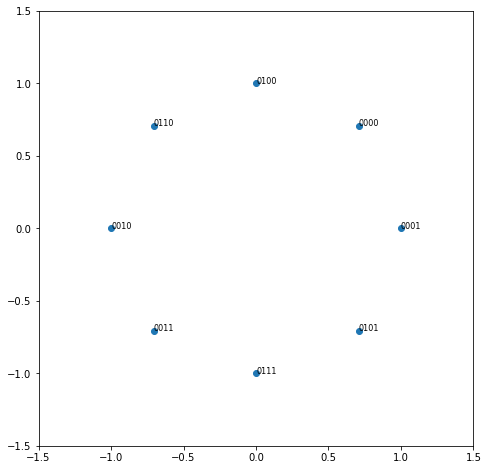

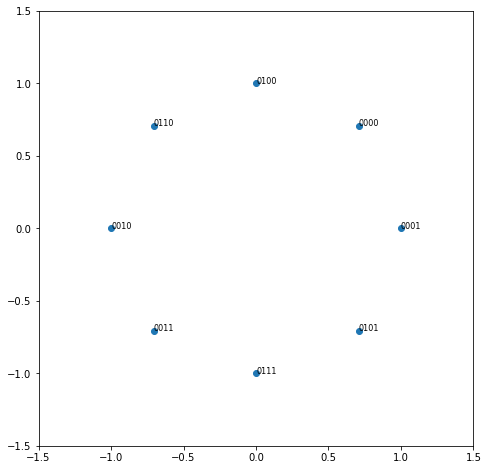

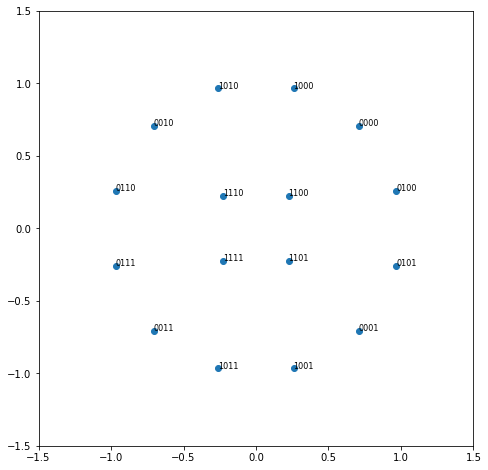

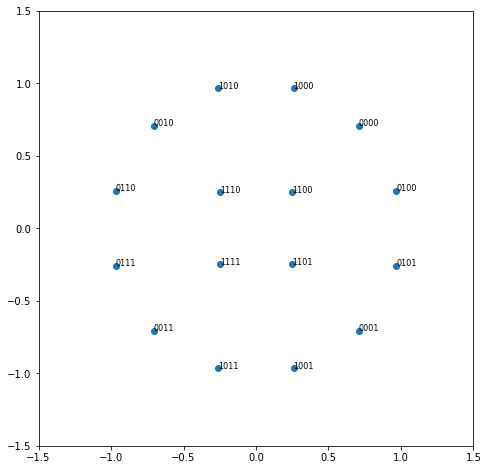

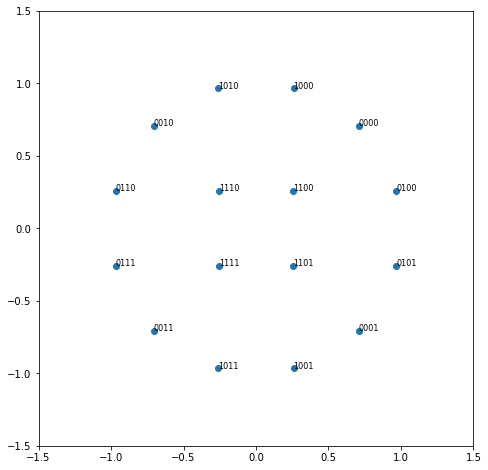

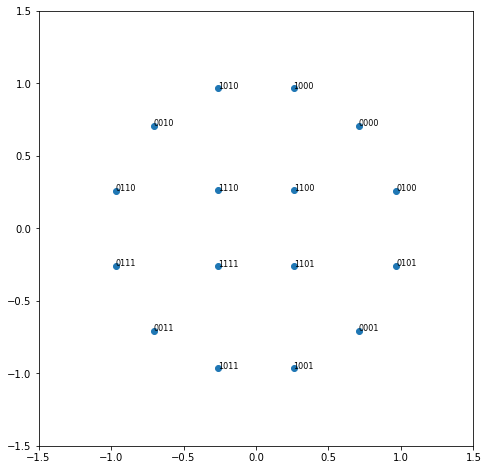

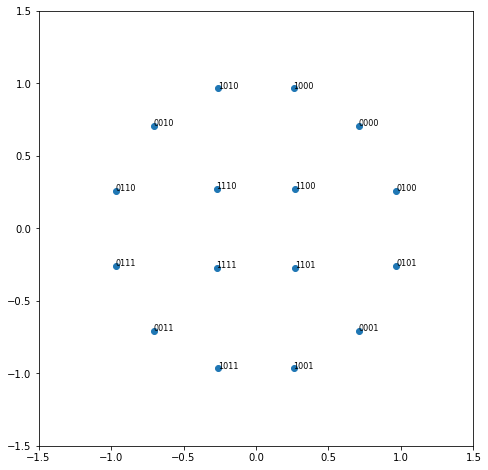

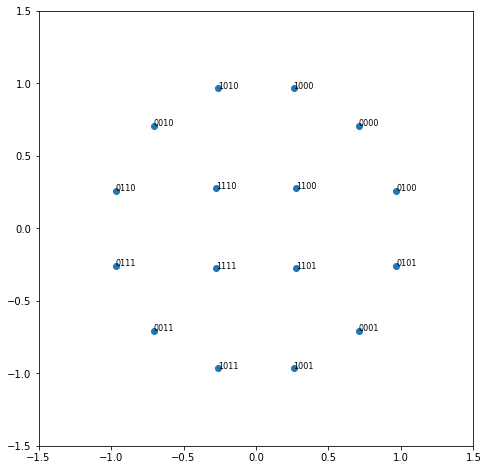

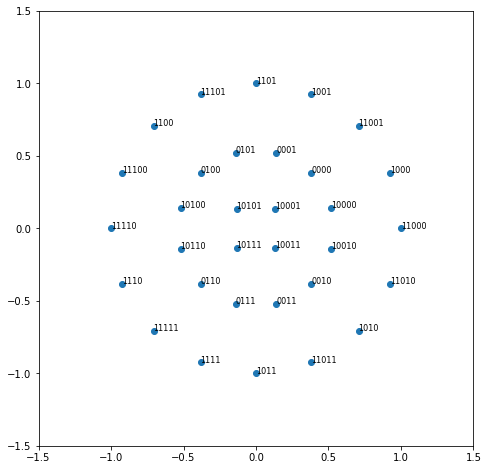

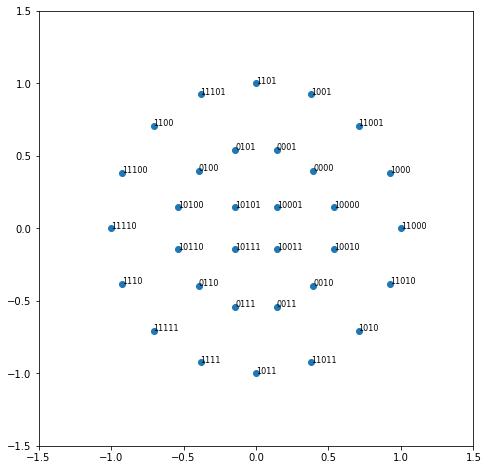

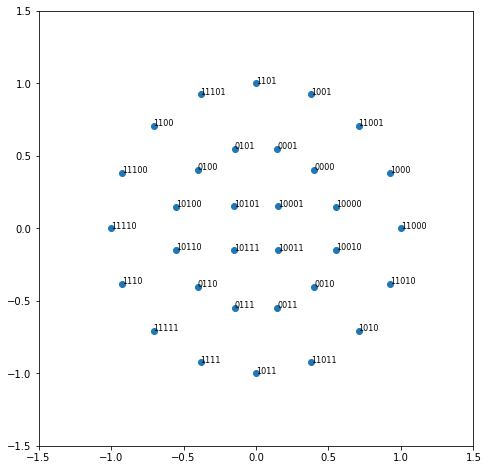

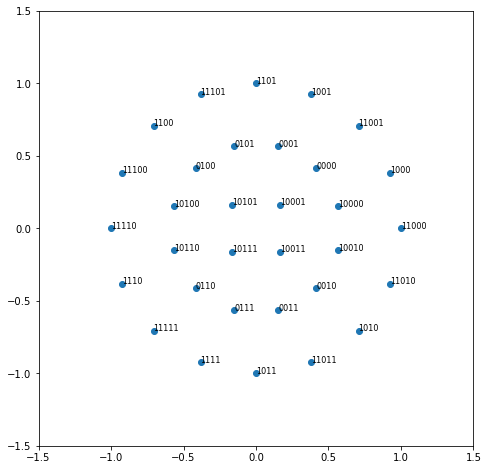

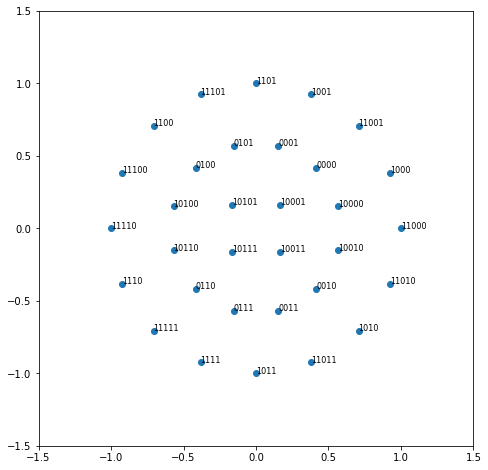

In [98]:
def generate_apsk_symbols(modcod_df):

    m1, m2, m3 = modcod_df.m1, modcod_df.m2, modcod_df.m3
    total_symbols = m1 + m2 + m3

    symbols = np.zeros(total_symbols, dtype=np.complex_)

    s = 0   # symbol counter

    g1 = modcod_df.gamma1
    g2 = modcod_df.gamma2
    g23 = 1.0 if g2 == 1.0 else g2 / g1

    r = (1/g1) * (1/g23) * 1
    phi = np.deg2rad(modcod_df.phi1)
    m = m1
    for j in range(m1):
        symbols[s] = r * np.exp(1j*(phi + j*(2*np.pi)/m))
        s = s + 1

    r = (1/g23) * 1
    phi = np.deg2rad(modcod_df.phi2)
    m = m2
    for j in range(m2):
        symbols[s] = r * np.exp(1j*(phi + j*(2*np.pi)/m))
        s = s + 1

    r = 1
    phi = np.deg2rad(modcod_df.phi3)
    m = m3
    for j in range(m3):
        symbols[s] = r * np.exp(1j*(phi + j*(2*np.pi)/m))
        s = s + 1

    grey_mapping = np.zeros(total_symbols)
    for s in range(total_symbols):
        grey_mapping[s] = modcod_df['g%d' % s]

    return symbols, grey_mapping

for i, row in modcod_df.iterrows():
    symbols, grey_mapping = generate_apsk_symbols(row)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(np.real(symbols), np.imag(symbols))
    for m in range(len(grey_mapping)):
        ax.text(np.real(symbols[m]), np.imag(symbols[m]),
                "{:04b}".format(int(grey_mapping[m])),
                fontsize=8)

    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))
    ax.set_aspect('equal', 'box')

    plt.show()
    pass

In [99]:
def prbs31(code):

    for i in range(32):
        next_bit = ~((code>>30) ^ (code>>27)) & 0x01
        code = ((code<<1) | next_bit) & 0xFFFFFFFF

    return code

def generate_prbs31_symbols(N_symbols, mod_order):
    code = 0x10101010 # Seed

    symbols = [0] * int(N)
    i = 0

    while i < N:
        b = mod_order - 1
        while b >= 0:
            code = prbs31(code)
            symbols[i] = symbols[i] | ((code & 0x01) << b)
            b = b - 1
        i = i + 1

    return symbols

# mod_order = 2
# N = 100 * 2**mod_order
#
# binary_symbol_list = generate_prbs31_symbols(N, 2)

C:\git\hermes-optimization\cenv\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\git\hermes-optimization\cenv\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


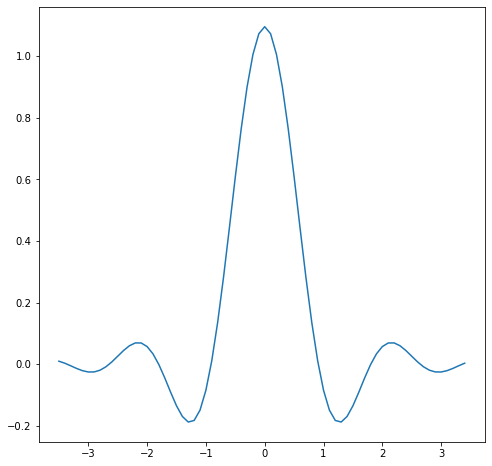

In [100]:
def grey_code(n):
    return n ^ (n >> 1)

def raised_root_cosine(upsample, num_positive_lobes, alpha):
    """
    Root raised cosine (RRC) filter (FIR) impulse response.

    upsample: number of samples per symbol

    num_positive_lobes: number of positive overlaping symbols
    length of filter is 2 * num_positive_lobes + 1 samples

    alpha: roll-off factor
    """

    N = upsample * (num_positive_lobes * 2 + 1)
    t = (np.arange(N) - N / 2) / upsample

    # result vector
    h_rrc = np.zeros(t.size, dtype=np.float)

    # index for special cases
    sample_i = np.zeros(t.size, dtype=np.bool)

    # deal with special cases
    subi = t == 0
    sample_i = np.bitwise_or(sample_i, subi)
    h_rrc[subi] = 1.0 - alpha + (4 * alpha / np.pi)

    subi = np.abs(t) == 1 / (4 * alpha)
    sample_i = np.bitwise_or(sample_i, subi)
    h_rrc[subi] = (alpha / np.sqrt(2)) \
                * (((1 + 2 / np.pi) * (np.sin(np.pi / (4 * alpha))))
                + ((1 - 2 / np.pi) * (np.cos(np.pi / (4 * alpha)))))

    # base case
    sample_i = np.bitwise_not(sample_i)
    ti = t[sample_i]
    h_rrc[sample_i] = np.sin(np.pi * ti * (1 - alpha)) \
                    + 4 * alpha * ti * np.cos(np.pi * ti * (1 + alpha))
    h_rrc[sample_i] /= (np.pi * ti * (1 - (4 * alpha * ti) ** 2))

    return t, h_rrc

upsample = 10

t, h_rrc = raised_root_cosine(upsample, 3, 0.35)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(t, h_rrc)

In [101]:
def modulate(symbols, grey_mapping, bit_sequence):

    mod_order = int(np.log2(len(symbols)))

    N_sym = int(len(bit_sequence) / mod_order)

    sym_sequence = np.zeros(N_sym, dtype=np.complex_)

    for i in range(N_sym):
        bits = bit_sequence[i * mod_order:(i + 1) * mod_order]
        dec_value = 0
        for j in range(len(bits)):
            dec_value = dec_value | (bits[j] << (mod_order - 1 - j))
        grey_value = grey_code(dec_value)
        sym_sequence[i] = symbols[np.where(grey_mapping == grey_value)]

    return sym_sequence


Vs = 1.00V
Vk/Vs = 0.00
Vk = 0.00V
γ = 0.50


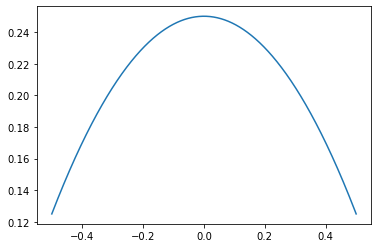

In [102]:
Vs = 1
VkVs = 00
Vk = VkVs * Vs

gamma = 0.5*(VkVs + 1)

amaxVs = 0.5*(1 - VkVs)

a = np.linspace(0, amaxVs, int(1000/2) + 1)
Pdiss = gamma*(1- gamma) - (a**2)/2

#Pdiss = gamma*(gamma-1) - (A**2)/2
# Pdiss = Amax - A

a = np.concatenate((-1*np.flip(a[1:]), a[1:]))
Pdiss = np.concatenate((np.flip(Pdiss[1:]), Pdiss[1:]))

# a = np.linspace(0, 1, 1000)
# Pdiss = 0.25 - (a - 0.5)**2

fig, ax = plt.subplots()
ax.plot(a, Pdiss)

print("Vs = %0.2fV" % Vs)
print("Vk/Vs = %0.2f" % VkVs)
print("Vk = %0.2fV" % Vk)
print("γ = %0.2f" % gamma)
# print("Amax/Vs = %0.2f" % AmaxVs)
# print("Amax = %0.2fV" % Amax)
# print("Pout = %0.2fW" % AmaxVs)

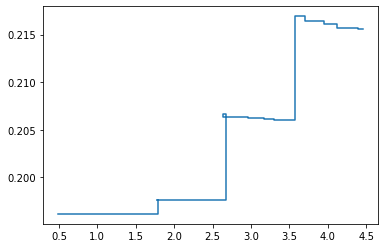

In [127]:
plt.close()

max_mod_order = 5
N_sym = 100 * max_mod_order
N_bit = N_sym * 2**max_mod_order

bit_seq = np.random.randint(0, 2, N_bit)

eta_maee = np.zeros(len(modcod_df))
papr = np.zeros(len(modcod_df))
EPD = np.zeros(len(modcod_df))

selection_df = modcod_df.loc[[3,13,18,23]]
selection_df = modcod_df

mag_list = [None] * len(selection_df)
filt_sym_seq_list = [None] * len(selection_df)

# Generate symbols
for i, row in selection_df.iterrows():

    symbols, grey_mapping = generate_apsk_symbols(row)
    mod_order = int(np.log2(len(symbols)))

    seq_len = int((N_sym / 5) * mod_order * (2**mod_order))
    sym_seq = modulate(symbols, grey_mapping, bit_seq[:seq_len])
    filt_sym_seq = np.convolve(sym_seq.repeat(upsample), h_rrc)
    filt_sym_seq = filt_sym_seq / np.max(np.abs(filt_sym_seq))

    mag = np.concatenate((np.abs(filt_sym_seq), -1.0*np.abs(filt_sym_seq)))

    filt_sym_seq_list[i] = filt_sym_seq
    mag_list[i] = mag

# Calculate metrics
for i, row in selection_df.iterrows():

    filt_sym_seq = filt_sym_seq_list[i]
    mag = mag_list[i]

    # PAPR
    papr[i] = np.max(np.abs(filt_sym_seq))**2 / np.mean(np.abs(filt_sym_seq))**2

    # MAEE
    # from scipy.stats import gaussian_kde
    # x_maee = np.linspace(-1, 1, 1000)
    # gkde = gaussian_kde(mag)
    # pdf_maee = gkde.evaluate(x_maee)

    #bins = np.floor(mag.min()),np.ceil(mag.max())
    pdf_maee_2, edge_maee_2 = np.histogram(mag, bins=1000, density=1)
    x_maee_2 = edge_maee_2[:-1]
    #pdf_maee_2 = pdf_maee_2 / 2 # Divide by two because double sided
    pdf_maee_2 = pdf_maee_2*np.diff(edge_maee_2)

    # fig, ax = plt.subplots(figsize=(8,4))
    # # ax.plot(x_maee, pdf_maee)
    # ax.plot(x_maee_2, pdf_maee_2)
    # ax.plot(x_maee_2, Pdiss)

    EPD[i] = np.sum(pdf_maee_2 * Pdiss)
    Ptx = (np.max(a)**2 / 2)

    eta_maee[i] = Ptx / (Ptx + EPD[i])
    pass

fig, ax = plt.subplots(1,1)
#selection_df = selection_df.sort_values('eta')

ax.step(selection_df.eta,EPD)

modcod_df['maee'] = eta_maee
modcod_df['papr'] = papr

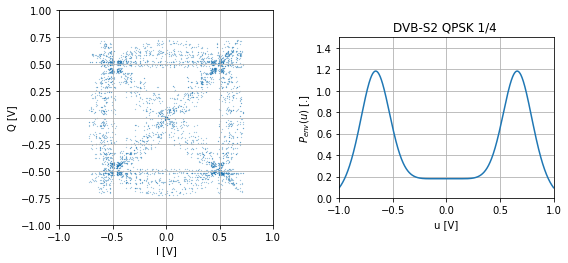

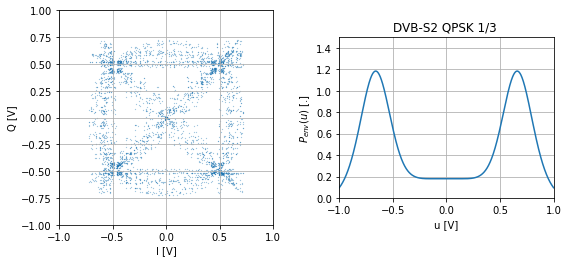

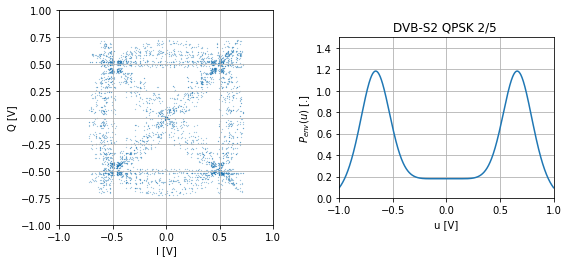

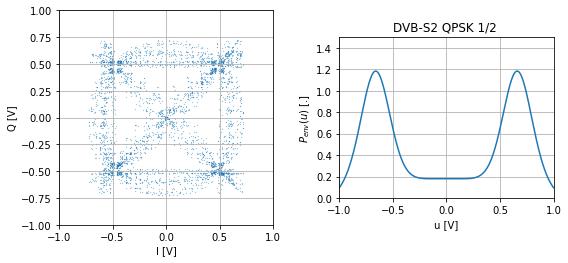

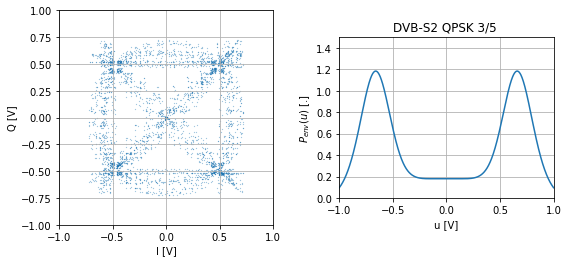

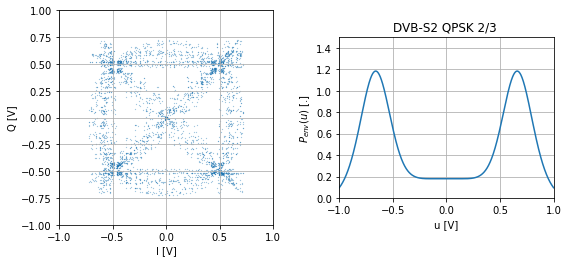

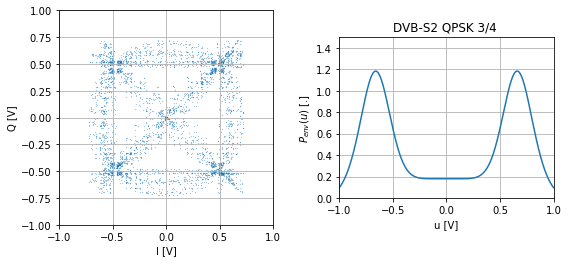

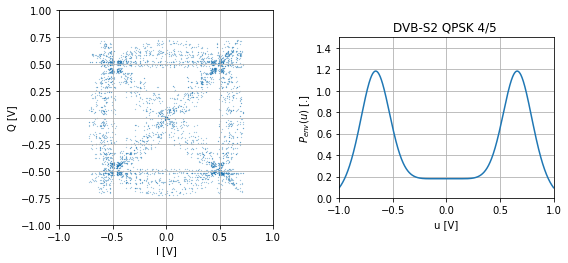

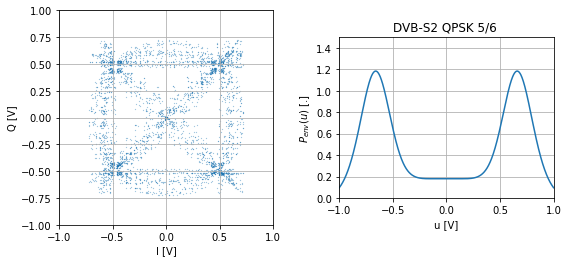

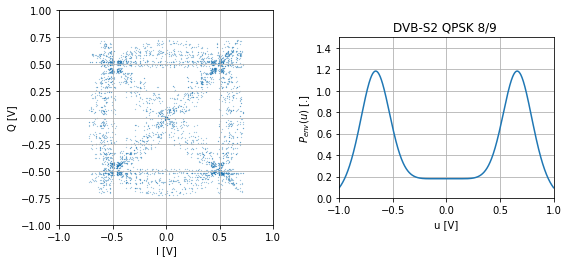

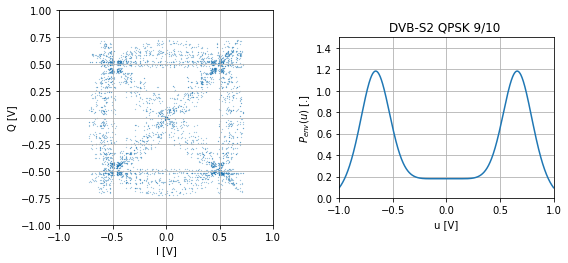

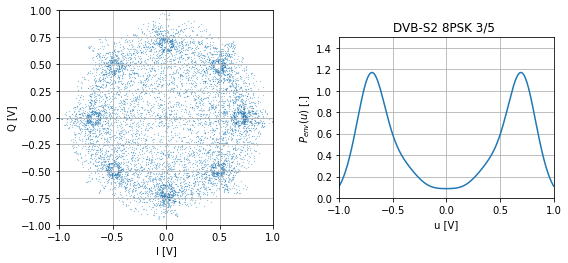

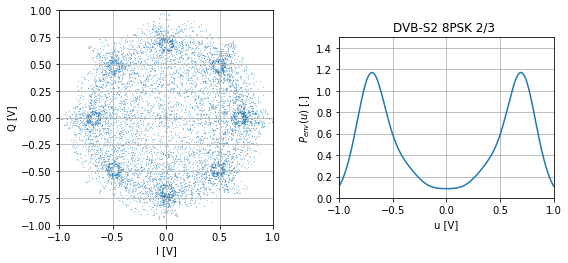

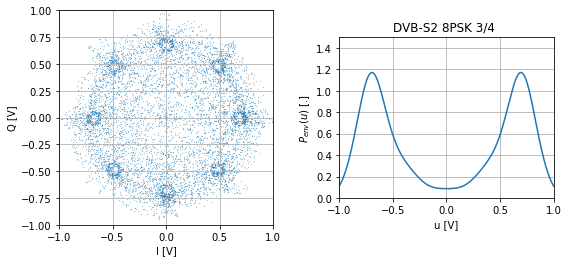

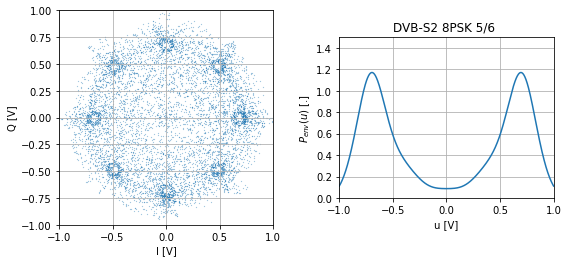

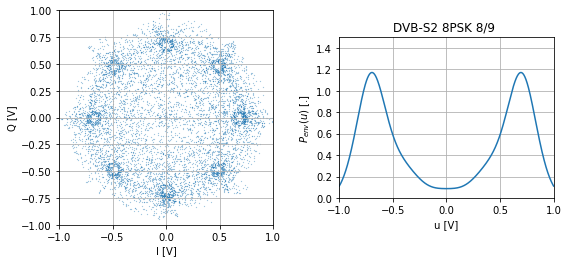

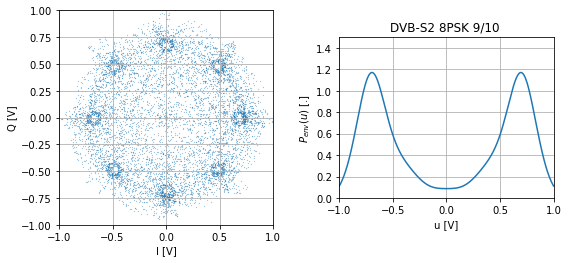

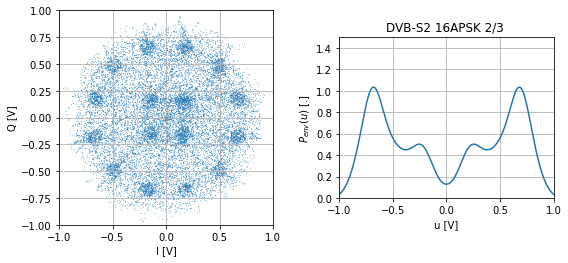

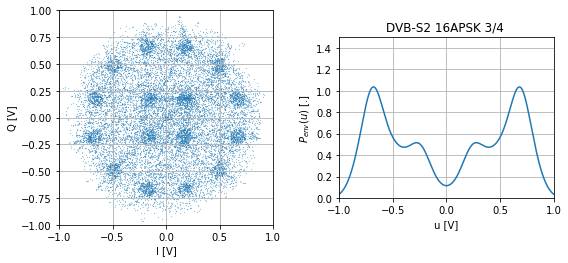

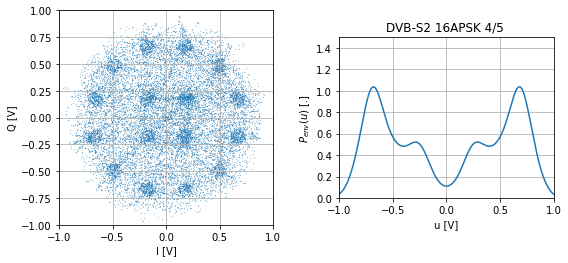

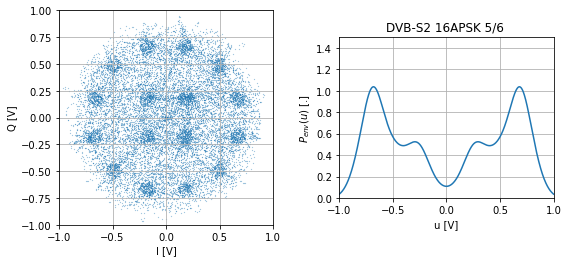

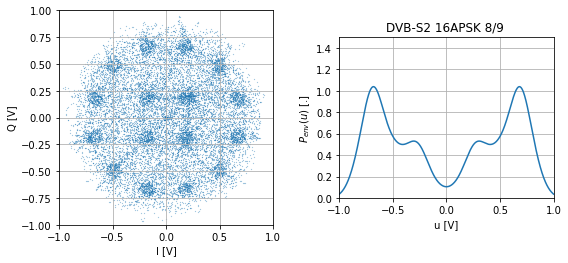

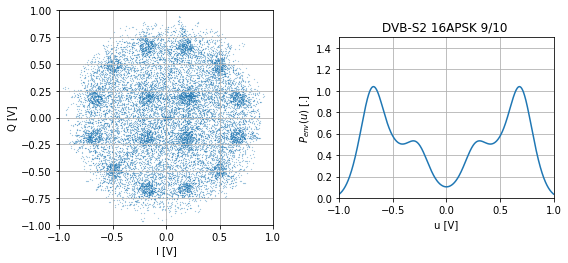

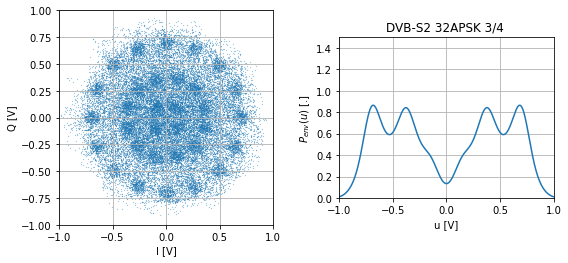

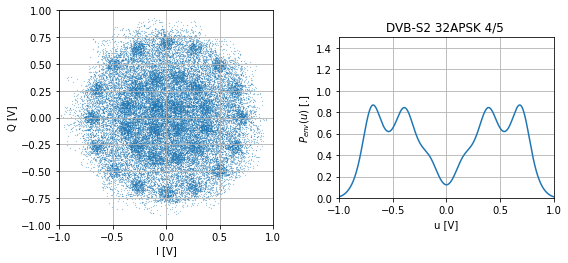

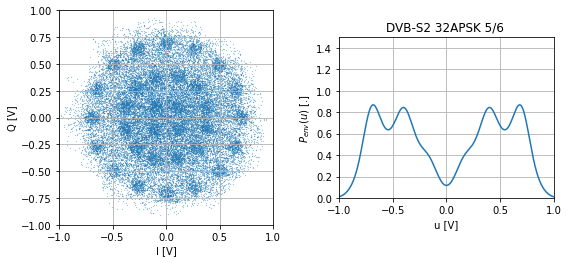

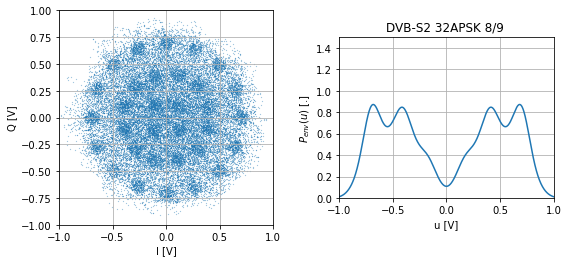

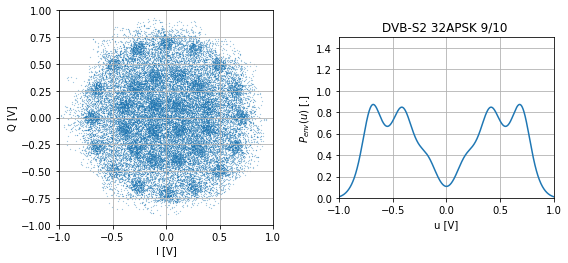

In [117]:
plt.close()

for i, row in selection_df.iterrows():

    mag = mag_list[i]
    filt_sym_seq = filt_sym_seq_list[i]

    #ax[1].hist(mag, bins=10000, density=True,histtype='step')
    #plt.show()
    from scipy.stats import gaussian_kde

    lim = 1.0

    gkde = gaussian_kde(mag)
    x_pdf = np.linspace(-1*lim, lim, 1000)
    #x_lim = np.linspace(0, 1, 1000)
    #x_pdf = np.linspace(np.min(mag), np.max(mag), 1000)

    pdf = gkde.evaluate(x_pdf)

    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].scatter(np.real(filt_sym_seq), np.imag(filt_sym_seq), 0.1, marker='.')
    ax[0].set_xlim((-1*lim, lim))
    ax[0].set_ylim((-1*lim, lim))
    ax[0].set_xlabel('I [V]')
    ax[0].set_ylabel('Q [V]')
    ax[0].set_aspect('equal', 'box')
    #ax[0].set_title(modcod_df.loc[i].label)
    ax[0].grid(True)
    #plt.show()

    ax[1].plot(x_pdf, pdf)
    ax[1].set_xlim((-1*lim, lim))
    ax[1].set_ylim((0, 1.5))
    ax[1].set_aspect('equal', 'box')
    ax[1].grid(True)
    ax[1].set_title(modcod_df.loc[i].label)
    ax[1].set_xlabel('u [V]')
    ax[1].set_ylabel('$P_{env}(u)$ [.]')

    # ax[1].hist(mag, bins=1000, density=True)
    # ax[1].plot(x_pdf, Pdiss / np.max(Pdiss))
    # ax[1].plot(x_pdf, pdf * Pdiss / np.max(Pdiss))

    def to_norm(x):
        return x / np.max(np.abs(x_pdf))

    def from_norm(x):
        return x * np.max(np.abs(x_pdf))

    # secax_x2 = ax[1].secondary_xaxis(-0.25, functions=(to_norm, from_norm))
    # secax_x2.set_xlabel('norm. u [V]')
    # secax_x2.set_xlim((-1.1, 1.1))

    plt.tight_layout()
    plt.savefig('D:/git/thesis_report_ae/figures/envelope_voltage_%s.pdf' % modcod_df.loc[i].label_string[:-1])

    plt.show()

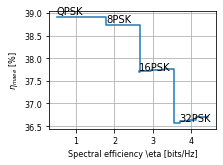

In [128]:
fig, ax = plt.subplots(1,1)
#selection_df = selection_df.sort_values('eta')

ax.step(selection_df.eta, selection_df.maee * 100)

ax.text(selection_df.eta[0], selection_df.maee[0] * 100 + .05, 'QPSK')
ax.text(selection_df.eta[11], selection_df.maee[11] * 100 + .05, '8PSK')
ax.text(selection_df.eta[17], selection_df.maee[17] * 100 + .05, '16PSK')
ax.text(selection_df.eta[23], selection_df.maee[23] * 100 + .05, '32PSK')

#ax.plot(papr)
# for i, row in modcod_df.iterrows():
#     ax.text(row.eta, row.maee, row.order_name + row.rate)

#ax.set_ylim((22.8, 23.7))
ax.grid()
ax.set_ylabel('$\eta_{maee}$ [%]')
ax.set_xlabel('Spectral efficiency \eta [bits/Hz]')

from pyreport import PlotUtil
PlotUtil.apply_report_formatting()
plt.tight_layout()
plt.savefig('D:/git/thesis_report_ae/figures/maee_dvb_s2.pdf')

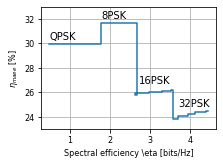

In [106]:
fig, ax = plt.subplots(1,1)
#selection_df = selection_df.sort_values('eta')

papr_db = 10*np.log10(selection_df.papr)
#ax.step(selection_df.eta, papr_db)
eta_papr = 0.5*10**(-papr_db/20)

ax.step(selection_df.eta, eta_papr * 100)
ax.text(selection_df.eta[0], eta_papr[0] * 100 + .4, 'QPSK')
ax.text(selection_df.eta[11], eta_papr[11] * 100 + .4, '8PSK')
ax.text(selection_df.eta[17] + 0.1, eta_papr[17] * 100 + 1, '16PSK')
ax.text(selection_df.eta[23], eta_papr[23] * 100 + 1, '32PSK')

#ax.plot(papr)
# for i, row in modcod_df.iterrows():
#     ax.text(row.eta, row.maee, row.order_name + row.rate)

ax.set_ylim((23, 33))
ax.grid()
ax.set_ylabel('$\eta_{maee}$ [%]')
ax.set_xlabel('Spectral efficiency \eta [bits/Hz]')

from pyreport import PlotUtil
PlotUtil.apply_report_formatting()
plt.tight_layout()
plt.savefig('D:/git/thesis_report_ae/figures/papr_dvb_s2.pdf')
